# iLab Project: Group 7-2

#### Federated Learning for Gastric Cancer Detection - gashissdb

David Bain 91082596

In [1]:
from pathlib import Path
import random
import logging

import boto3
from PIL import Image
import pandas as pd
import numpy as np
from typing import List, Tuple
from typing import Optional
from botocore.exceptions import BotoCoreError, ClientError
from matplotlib import pyplot as plt
import json
import seaborn as sns

import torchvision.models as models
import torchvision.transforms as v2
import torch
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Read from disk

In [2]:
image_dir = Path('~/Development/UTS/ilab-07-2/120_dataset/clinic_0').expanduser()

# Configure logging
logging.basicConfig(level=logging.INFO)

In [3]:
def read_image_with_label(file_path, label):
    try:
        with Image.open(file_path) as image:  # Ensure proper file handling
            image.load()  # Load image data into memory
            return image, label
    except Exception as e:
        logging.error(f"Error reading {file_path}: {e}")
        return None, None


def process_directory(directory_path, label, batch_size=100):
    image_files = [(directory_path / f) for f in directory_path.iterdir()
                   if f.suffix in ['.jpg', '.png']]

    images_with_labels = []

    for i, file_path in enumerate(image_files):
        img, lbl = read_image_with_label(file_path, label)
        if img is not None:
            images_with_labels.append((img, lbl))

        # Process in batches to avoid memory issues
        if (i + 1) % batch_size == 0:
            #logging.info(f"Processed {i + 1} / {len(image_files)} images from {directory_path}")
            yield images_with_labels
            images_with_labels = []

    # Yield remaining images
    if images_with_labels:
        yield images_with_labels


def read_images_for_classification(base_directory, batch_size=100):
    abnormal_dir = base_directory / '1'
    normal_dir = base_directory / '0'

    abnormal_images_batches = process_directory(abnormal_dir, label=1, batch_size=batch_size)
    normal_images_batches = process_directory(normal_dir, label=0, batch_size=batch_size)

    for abnormal_batch in abnormal_images_batches:
        for img, lbl in abnormal_batch:
            yield img, lbl

    for normal_batch in normal_images_batches:
        for img, lbl in normal_batch:
            yield img, lbl


In [4]:
images = []

for img, lbl in read_images_for_classification(image_dir):
    # Process each image and label here
    images.append((lbl, img))


Define function to print a handful of original images

In [5]:
def plot_images(images: List[Image], titles: List[str], rows: int, cols: int) -> None:
    """
    Plot a list of images with their titles using matplotlib.

    :param images: List of images to plot
    :param titles: List of titles corresponding to the images
    :param rows: Number of rows in the plot
    :param cols: Number of columns in the plot
    """
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Read images and plot

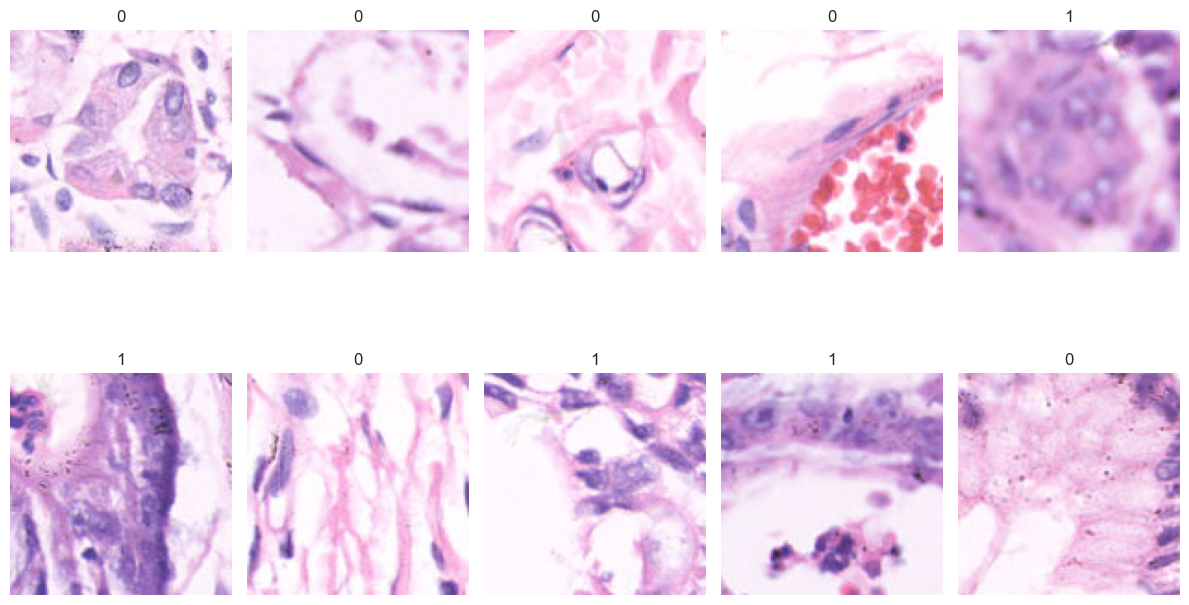

In [6]:
# Access a random sample of 5 images
clinic_1_images = images

if clinic_1_images:
    random_sample = random.sample(clinic_1_images, min(10, len(clinic_1_images)))
    sampled_images = [img_data for label, img_data in random_sample]
    sampled_titles = [label for label, img_data in random_sample]

    # Display images using matplotlib
    num_images = len(sampled_images)
    plot_images(sampled_images, sampled_titles, 2, int(np.ceil(num_images / 2)))


In [7]:
sampled_images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120>]

Resolution of images are small in size and vary. This will limit the transfer learning models used 

Image Transformation
1) Transform to tensor
2) Normalise
3) Augmentation

In [8]:
def preprocess_images(images: List[Tuple[int, Image]], size: List[int]) -> List[Tuple[int, Image]]:
    
    transformed_images = []
    transform = v2.Compose([
        v2.Resize(size, interpolation=Image.BICUBIC),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    for label, image in images:
        transformed_images.append((label, transform(image)))
    
    return transformed_images
    


In [9]:
#target_size = [60, 60]
target_size = [224, 224]

clinic_1_ds = preprocess_images(clinic_1_images, target_size)

In [10]:
print(clinic_1_ds[0], clinic_1_ds[-1])

(1, tensor([[[2.0777, 2.0777, 2.0605,  ..., 1.1015, 1.3755, 1.5468],
         [2.0605, 2.0605, 2.0605,  ..., 1.0844, 1.3242, 1.4612],
         [2.0263, 2.0263, 2.0434,  ..., 1.0159, 1.1872, 1.2899],
         ...,
         [2.0605, 2.0777, 2.0948,  ..., 1.1700, 1.1529, 1.1529],
         [2.0605, 2.0777, 2.0948,  ..., 1.1700, 1.1872, 1.1872],
         [2.0605, 2.0777, 2.0948,  ..., 1.1700, 1.1872, 1.1872]],

        [[1.7983, 1.7458, 1.6408,  ..., 0.1877, 0.5028, 0.6604],
         [1.7108, 1.6758, 1.5882,  ..., 0.1877, 0.4503, 0.5903],
         [1.5357, 1.5007, 1.4657,  ..., 0.1527, 0.3277, 0.4153],
         ...,
         [1.9909, 2.0084, 2.0259,  ..., 0.6429, 0.6254, 0.6254],
         [1.9909, 2.0084, 2.0259,  ..., 0.6604, 0.6604, 0.6604],
         [1.9909, 2.0084, 2.0259,  ..., 0.6604, 0.6779, 0.6779]],

        [[2.4308, 2.4134, 2.3786,  ..., 1.3502, 1.5768, 1.7163],
         [2.3786, 2.3611, 2.3437,  ..., 1.3154, 1.5245, 1.6465],
         [2.2740, 2.2740, 2.2740,  ..., 1.2457, 1.3851

In [11]:
def unnormalize(tensor: torch.Tensor, mean: List[float], std: List[float]) -> torch.Tensor:
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


In [12]:
# Example usage:
i = 0
unnormalized_tensor = unnormalize(clinic_1_ds[i][1], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Shape of the tensor: torch.Size([3, 224, 224])
Data type of the tensor: torch.float32
Tensor contents:
 tensor([[[0.9608, 0.9608, 0.9569,  ..., 0.7373, 0.8000, 0.8392],
         [0.9569, 0.9569, 0.9569,  ..., 0.7333, 0.7882, 0.8196],
         [0.9490, 0.9490, 0.9529,  ..., 0.7176, 0.7569, 0.7804],
         ...,
         [0.9569, 0.9608, 0.9647,  ..., 0.7529, 0.7490, 0.7490],
         [0.9569, 0.9608, 0.9647,  ..., 0.7529, 0.7569, 0.7569],
         [0.9569, 0.9608, 0.9647,  ..., 0.7529, 0.7569, 0.7569]],

        [[0.8588, 0.8471, 0.8235,  ..., 0.4980, 0.5686, 0.6039],
         [0.8392, 0.8314, 0.8118,  ..., 0.4980, 0.5569, 0.5882],
         [0.8000, 0.7922, 0.7843,  ..., 0.4902, 0.5294, 0.5490],
         ...,
         [0.9020, 0.9059, 0.9098,  ..., 0.6000, 0.5961, 0.5961],
         [0.9020, 0.9059, 0.9098,  ..., 0.6039, 0.6039, 0.6039],
         [0.9020, 0.9059, 0.9098,  ..., 0.6039, 0.6078, 0.6078]],

        [[0.9529, 0.9490, 0.9412,  ..., 0.7098, 0.7608, 0.7922],
         [0.9412, 0

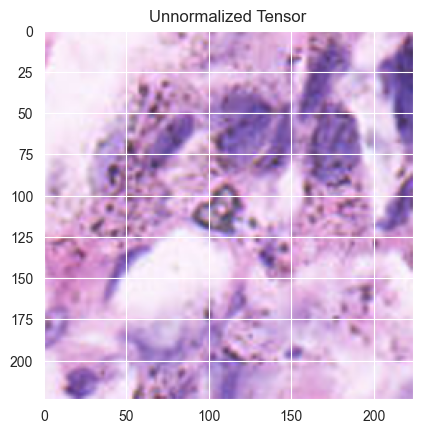

In [13]:
# Assuming unnormalized_tensor is a NumPy array or can be converted to one
print("Shape of the tensor:", unnormalized_tensor.shape)
print("Data type of the tensor:", unnormalized_tensor.dtype)
print("Tensor contents:\n", unnormalized_tensor)

plt.imshow(np.transpose(unnormalized_tensor, (1, 2, 0)))  # Transpose if necessary for HWC order
plt.title("Unnormalized Tensor")
plt.show()

In [14]:
train_ds_c1, test_ds_c1 = random_split(clinic_1_ds, [int(len(clinic_1_ds) * 0.8), len(clinic_1_ds) - int(len(clinic_1_ds) * 0.8)])

Create a custom Dataset for the images

In [15]:
# Create a custom Dataset for the images
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the item (label, image) from the list
        label, image = self.data[idx]
        # Return the image and label
        return image, label

Create an instance of the custom dataset

In [16]:
# Create custom datasets

train_dataset = CustomDataset(train_ds_c1)
test_dataset = CustomDataset(test_ds_c1)

In [17]:
train_dataset.__getitem__(0)

(tensor([[[1.2557, 1.1529, 0.9817,  ..., 2.1804, 2.2489, 2.2489],
          [1.4612, 1.3927, 1.2385,  ..., 2.1119, 2.1975, 2.2318],
          [1.8893, 1.8379, 1.7352,  ..., 1.9920, 2.1119, 2.1633],
          ...,
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318]],
 
         [[0.8880, 0.8179, 0.6954,  ..., 1.9559, 2.0259, 2.0784],
          [1.0980, 1.0630, 0.9755,  ..., 1.8859, 1.9559, 1.9909],
          [1.5357, 1.5532, 1.5182,  ..., 1.7458, 1.7983, 1.8333],
          ...,
          [2.3235, 2.3235, 2.3235,  ..., 2.3235, 2.3235, 2.3235],
          [2.3235, 2.3235, 2.3235,  ..., 2.3235, 2.3235, 2.3235],
          [2.3235, 2.3235, 2.3235,  ..., 2.3235, 2.3235, 2.3235]],
 
         [[2.2566, 2.1868, 2.0648,  ..., 2.6400, 2.6400, 2.6400],
          [2.3437, 2.3088, 2.2391,  ..., 2.5703, 2.6051, 2.6051],
          [2.5354, 2.5529, 2.5703,  ...,

Sample 0: Label = 1


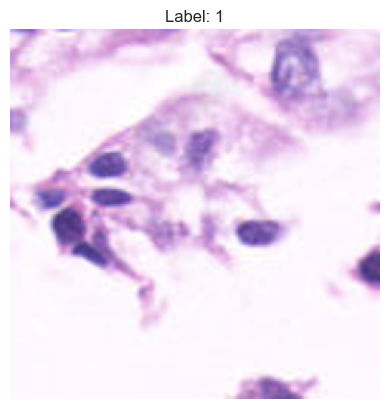

Sample 1: Label = 0


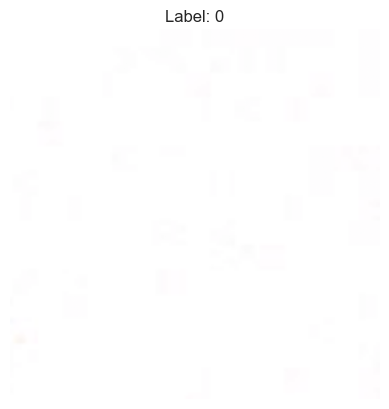

Sample 2: Label = 1


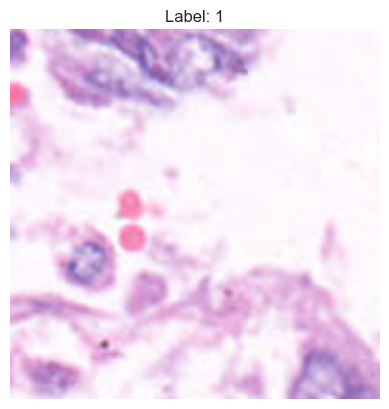

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def visualize_sample(image, label, mean, std):
    # Unnormalize the image
    image = unnormalize(image, mean, std)
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC if tensor

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


for i in range(3):  # Change the range to view more samples
    image, label = train_dataset[i]
    print(f"Sample {i}: Label = {label}")
    visualize_sample(image, label, mean, std)

In [19]:
label_count = {}
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label in label_count:
        label_count[label] += 1
    else:
        label_count[label] = 1

print("Label distribution in the training dataset:", label_count)


Label distribution in the training dataset: {1: 3747, 0: 6565}


Create a DataLoader

In [20]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Make sure this runs on Mac GPU

In [21]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Define the first Torchvision model: VGG16

In [22]:
# Load pre-trained VGG16 model
#model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze the parameters of the base model
#for param in model.features.parameters():
#    param.requires_grad = False
    
# Modify the classifier part for binary classification
#model.classifier[6] = nn.Sequential(
#    nn.Linear(model.classifier[6].in_features, 512),
#    nn.ReLU(),
#    nn.Dropout(p=0.5),
#    nn.Linear(512, 1),
#    nn.Sigmoid()
#)

#model.to(device)



VGG16 with varied dropout rate

In [23]:
# Load pre-trained VGG16 model
model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze the parameters of the base model
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier part for binary classification with a varied dropout rate
dropout_rate = 0.5  # Typical value used in the original VGG16 paper

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),  # Dropout after the first fully connected layer
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),  # Dropout after the second fully connected layer
    nn.Linear(2048, 1),
    nn.Sigmoid()  # Binary classification output
)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training Loop

In [24]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam with L2 regularization (weight decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # Reduce learning rate by 0.1 every 7 epochs



In [25]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):

    # Logging metrics
    metrics = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        y_true_train = []
        y_pred_train = []
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Ensure labels are float type
    
            optimizer.zero_grad()  # Zero the parameter gradients
    
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(-1)  # Flatten output to match labels shape
    
            # Loss computation and backpropagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * inputs.size(0)  # Sum up batch loss
    
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(outputs.cpu().detach().numpy() >= 0.5)  # Classification threshold of 0.5
    
        # Calculate metrics for training set if needed
        
        #train_accuracy = accuracy_score(y_true_train, y_pred_train)
    
        # Evaluate the model after every epoch
        model.eval()
        test_loss = 0
        y_true_test = []
        y_pred_test = []
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
    
                outputs = model(inputs)
                outputs = outputs.view(-1)  # Flatten output to match labels shape
    
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)  # Sum up batch loss
    
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(outputs.cpu().numpy() >= 0.5)  # Classification threshold of 0.5
    
        # Average losses
        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
    
        # Calculate metrics
        test_accuracy = accuracy_score(y_true_test, y_pred_test)
        test_precision = precision_score(y_true_test, y_pred_test)
        test_recall = recall_score(y_true_test, y_pred_test)
        test_f1 = f1_score(y_true_test, y_pred_test)
    
        # Log metrics
        #metrics['train_accuracy'].append(train_accuracy)
        metrics['train_loss'].append(train_loss)
        metrics['test_loss'].append(test_loss)
        metrics['test_accuracy'].append(test_accuracy)
        metrics['test_precision'].append(test_precision)
        metrics['test_recall'].append(test_recall)
        metrics['test_f1'].append(test_f1)
    
        # Step the scheduler based on the test loss
        scheduler.step(test_loss)
    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')
    
    return metrics
    


Test Classification results

In [26]:
# Call train_and_evaluate function

num_epochs = 15

metrics = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device)

# Optionally save metrics to a file
with open('results/metrics5.json', 'w') as f:
    json.dump(metrics, f)

Epoch [1/15], Training Loss: 0.4458, Test Loss: 0.3777
Test Accuracy: 0.8519, Precision: 0.8727, Recall: 0.6970, F1 Score: 0.7750
Epoch [2/15], Training Loss: 0.2932, Test Loss: 0.4530
Test Accuracy: 0.7751, Precision: 0.9417, Recall: 0.4110, F1 Score: 0.5723
Epoch [3/15], Training Loss: 0.2361, Test Loss: 0.3388
Test Accuracy: 0.8592, Precision: 0.7896, Recall: 0.8390, F1 Score: 0.8136
Epoch [4/15], Training Loss: 0.2034, Test Loss: 0.3619
Test Accuracy: 0.8554, Precision: 0.8169, Recall: 0.7797, F1 Score: 0.7978
Epoch [5/15], Training Loss: 0.1663, Test Loss: 0.3916
Test Accuracy: 0.8565, Precision: 0.8247, Recall: 0.7722, F1 Score: 0.7976
Epoch [6/15], Training Loss: 0.1372, Test Loss: 0.4676
Test Accuracy: 0.8511, Precision: 0.7652, Recall: 0.8559, F1 Score: 0.8080
Epoch [7/15], Training Loss: 0.1217, Test Loss: 0.7397
Test Accuracy: 0.8267, Precision: 0.9248, Recall: 0.5731, F1 Score: 0.7077
Epoch [8/15], Training Loss: 0.1140, Test Loss: 0.4855
Test Accuracy: 0.8546, Precision: 0

In [27]:
# Test the model after training
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        # Directly pass inputs through the model
        outputs = model(inputs)
        outputs = outputs.view(-1)  # Flatten output to match labels shape

        # Since the last layer of model.classifier includes Sigmoid,
        # outputs are already probabilities (between 0 and 1)
        predictions = torch.round(outputs)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())


# Convert lists to numpy arrays for metric calculations
true_labels = np.array(all_labels)
predicted_labels = np.array(all_predictions)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Format and print the calculated metrics
print(f'Model Evaluation Metrics:')
print(f'Accuracy        : {accuracy:.4f}')
print(f'Precision       : {precision:.4f}')
print(f'Recall          : {recall:.4f}')
print(f'F1 Score        : {f1:.4f}')
print('\nConfusion Matrix:')
print(conf_matrix)

Model Evaluation Metrics:
Accuracy        : 0.8596
Precision       : 0.8219
Recall          : 0.7871
F1 Score        : 0.8041

Confusion Matrix:
[[1474  161]
 [ 201  743]]


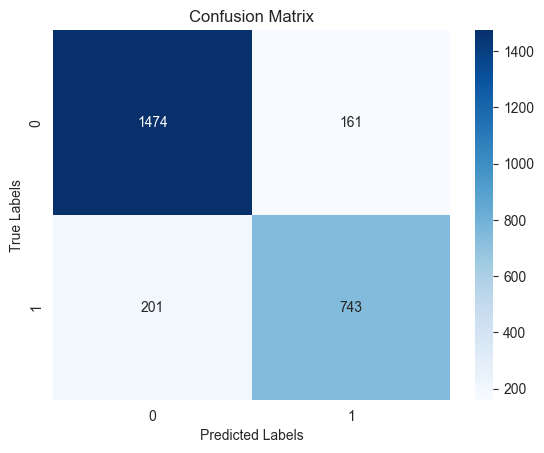

In [28]:
# Plotting the confusion matrix using seaborn for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Plot Results

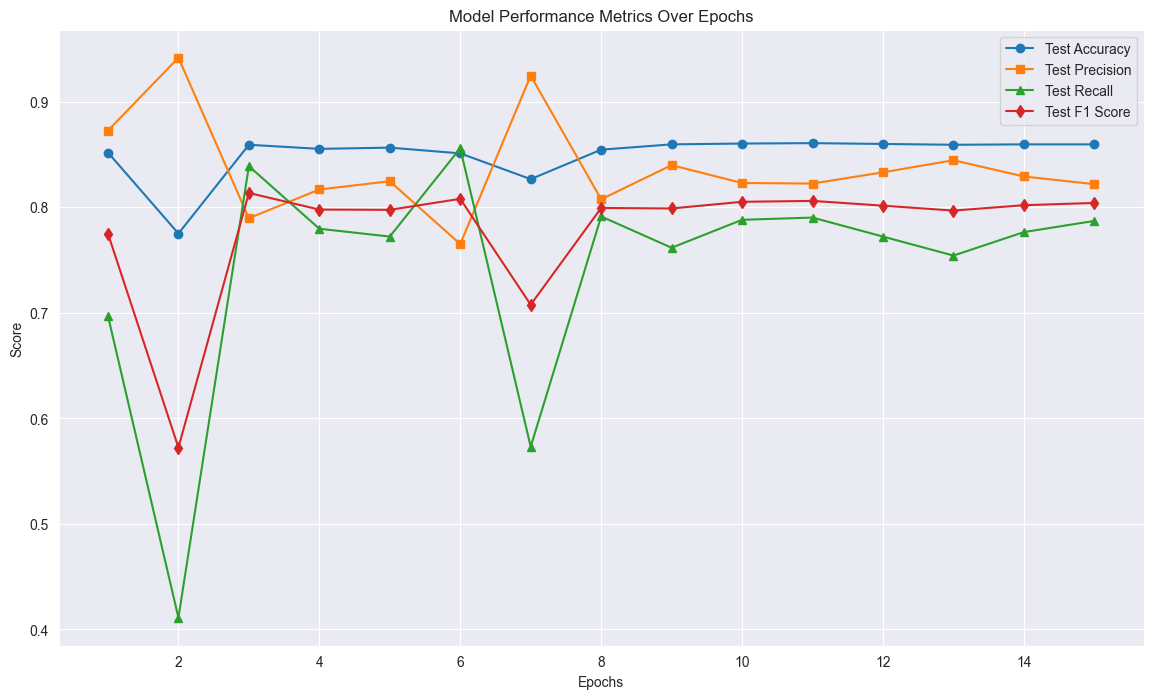

In [29]:
# Plot metrics in a single plot
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 8))

# Plotting all metrics in a single plot
plt.plot(epochs, metrics['test_accuracy'], label='Test Accuracy', marker='o')
plt.plot(epochs, metrics['test_precision'], label='Test Precision', marker='s')
plt.plot(epochs, metrics['test_recall'], label='Test Recall', marker='^')
plt.plot(epochs, metrics['test_f1'], label='Test F1 Score', marker='d')

plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()